<a href="https://colab.research.google.com/github/Kamruzzaman2200/Ai/blob/main/Depression_ML_DL_Adversarial_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1: Install Dependencies

In [1]:
!pip install pandas numpy scikit-learn xgboost lightgbm torch torchvision torchaudio captum matplotlib seaborn


#2: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from xgboost import XGBClassifier
import lightgbm as lgb


#3: Load Dataset (Remove sum_phq)

In [2]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/DataSets/dataset-2_9.csv")

# Drop sum_phq column if present
if "sum_phq" in df.columns:
    df = df.drop(columns=["sum_phq"])

print("Shape after removing sum_phq:", df.shape)
df.head()


Shape after removing sum_phq: (672, 55)


,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,PSQI10,PSQI11,PSQI12,PSQI13,PSQI14,PSQI15,PSQI16,PSQI17,PSQI18,PSQI19
0,15-30,Male,Overweight,Married,Higher secondary,Unemployed,High,Urban,Without family,Non-smoker,...,0,3,1,0,0,0,0,0,2,2
1,Above 30,Male,Normal,Married,Illiterate,Unemployed,Low,Rural,With family,Smoker,...,0,1,1,2,3,3,0,0,0,1
2,Above 30,Female,Normal,Unmarried,Primary,Unemployed,Middle,Rural,With family,Non-smoker,...,2,0,3,1,0,1,0,0,0,2
3,Above 30,Female,Normal,Married,Graduate/above,Student,Middle,Rural,With family,Non-smoker,...,1,1,0,1,1,2,0,0,0,1
4,Above 30,Male,Normal,Married,Graduate/above,Student,Middle,Rural,With family,Non-smoker,...,1,0,2,1,1,2,0,1,0,2


#4: Encode Categorical Variables

In [3]:
# Encode categorical features
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

df.head()


,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,PSQI10,PSQI11,PSQI12,PSQI13,PSQI14,PSQI15,PSQI16,PSQI17,PSQI18,PSQI19
0,0,1,1,0,1,3,0,1,1,0,...,0,3,1,0,0,0,0,0,2,2
1,1,1,0,0,2,3,1,0,0,1,...,0,1,1,2,3,3,0,0,0,1
2,1,0,0,1,3,3,2,0,0,0,...,2,0,3,1,0,1,0,0,0,2
3,1,0,0,0,0,2,2,0,0,0,...,1,1,0,1,1,2,0,0,0,1
4,1,1,0,0,0,2,2,0,0,0,...,1,0,2,1,1,2,0,1,0,2


#Quick EDA: class balance

/tmp/ipython-input-2814784314.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target, data=df, palette='viridis')


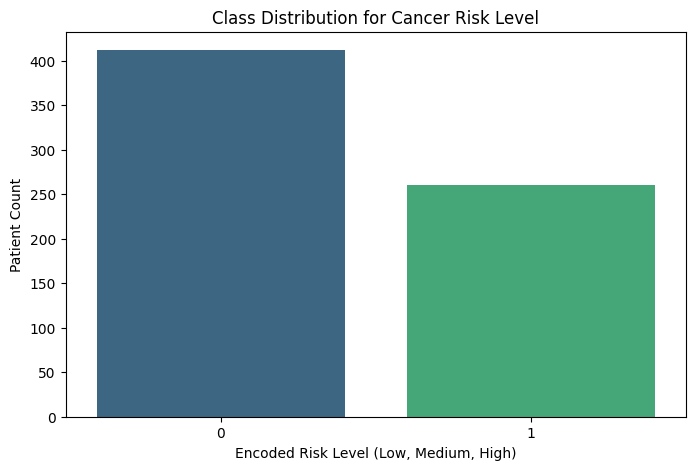

Class proportions:
Depression
0    0.613095
1    0.386905
Name: proportion, dtype: float64


In [19]:
target = "Depression"
plt.figure(figsize=(8, 5))
sns.countplot(x=target, data=df, palette='viridis')
plt.title(f'Class Distribution for Cancer Risk Level')
plt.xlabel('Encoded Risk Level (Low, Medium, High)')
plt.ylabel('Patient Count')
plt.show()

# Print the proportions of each class
print("Class proportions:")
print(df[target].value_counts(normalize=True).rename('proportion'))

#Quick EDA: correlations

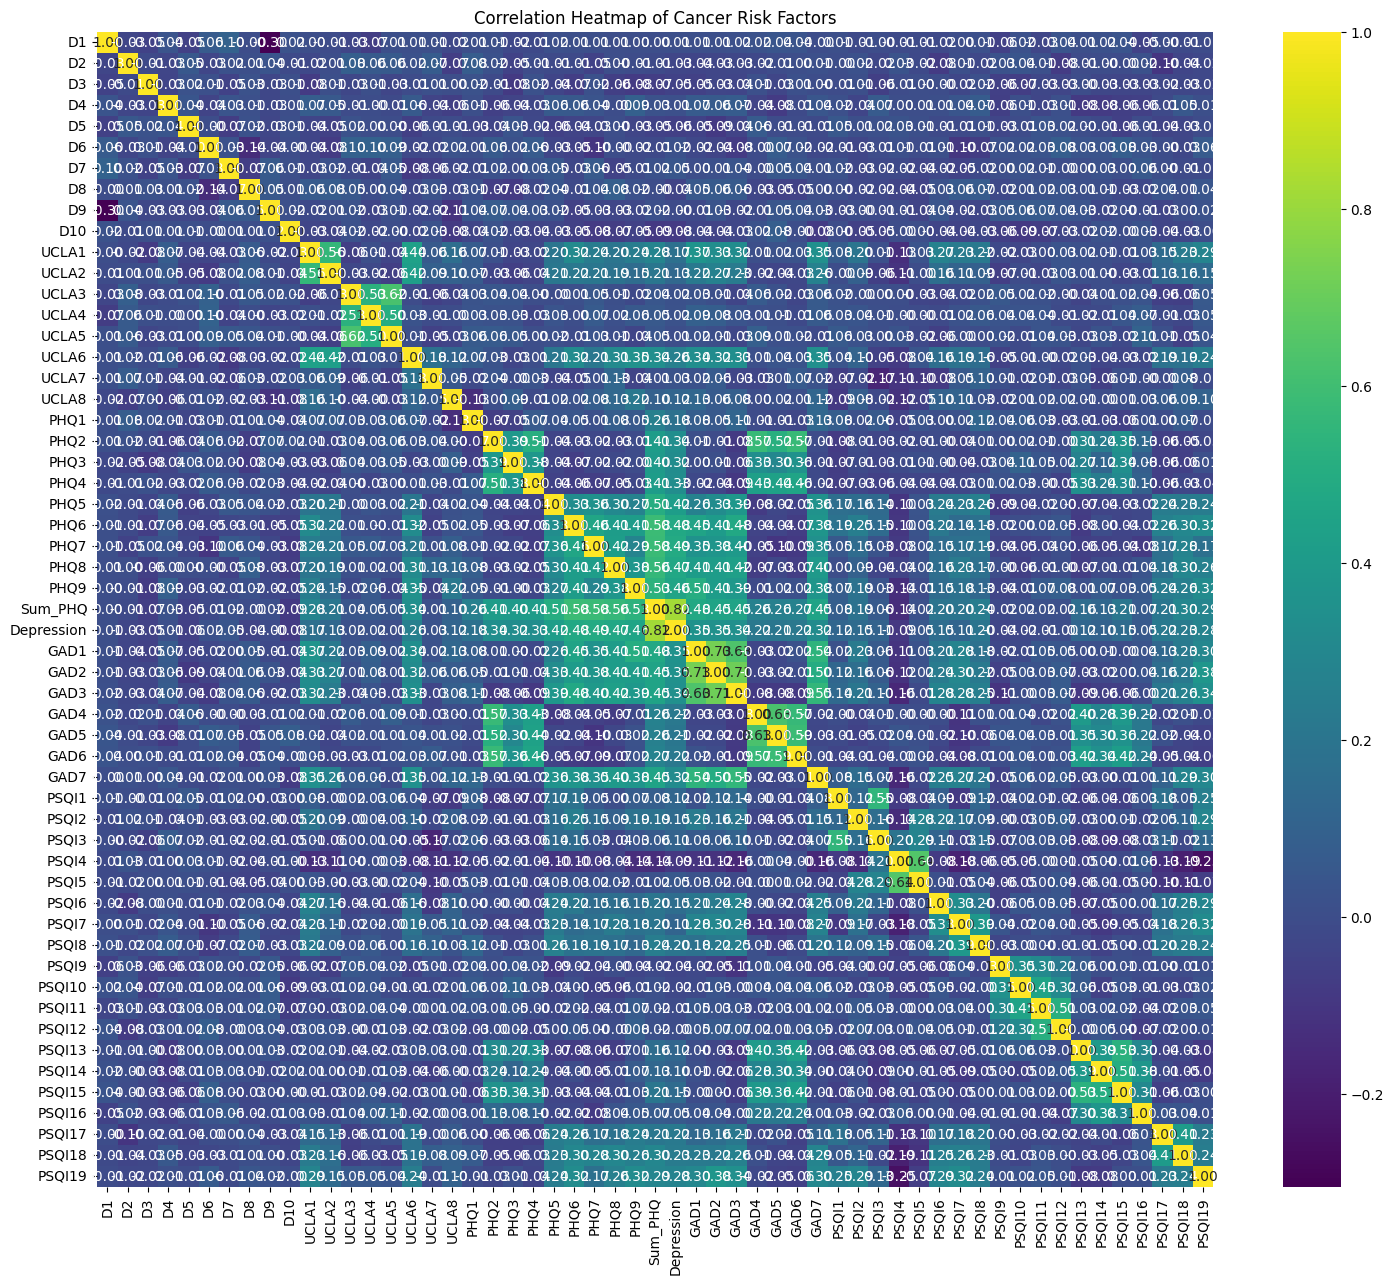

In [20]:
plt.figure(figsize=(18, 15))
sns.heatmap(df.corr(numeric_only=True), cmap='viridis', annot=True, fmt='.2f')
plt.title('Correlation Heatmap of Cancer Risk Factors')
plt.show()

#t-SNE visualization

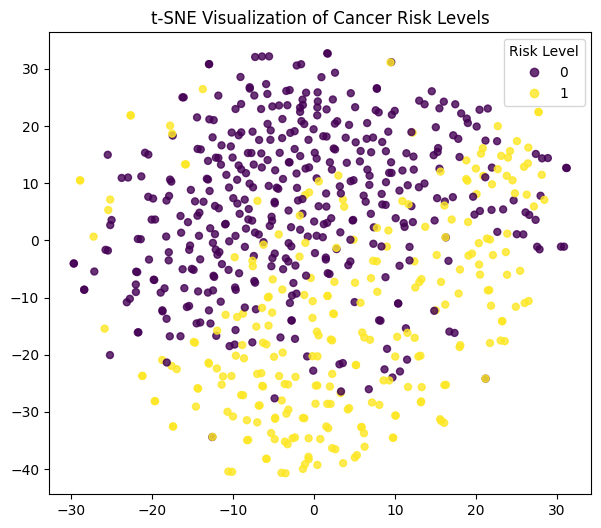

In [22]:
from sklearn.manifold import TSNE

X_vis = df.drop(columns=[target])
y_vis = df[target]

X_vis_scaled = StandardScaler().fit_transform(X_vis)

tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto')
X2 = tsne.fit_transform(X_vis_scaled)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(X2[:, 0], X2[:, 1], c=y_vis, s=25, alpha=0.8, cmap='viridis')
plt.title('t-SNE Visualization of Cancer Risk Levels')
plt.legend(handles=scatter.legend_elements()[0], labels=['0', '1'], title="Risk Level") # Corrected labels
plt.show()

#5: Split Features & Target

In [4]:
X = df.drop(columns=["Depression"])
y = df["Depression"]

print("Feature shape:", X.shape)
print("Target distribution:")
print(y.value_counts())


Feature shape: (672, 54)
Target distribution:
Depression
0    412
1    260
Name: count, dtype: int64


#6: Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (537, 54)  Test size: (135, 54)


#7: Standardize Features

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#🔹 Classical ML Models

#8: Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1:", f1_score(y_test, y_pred_lr, average="weighted"))
print("AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))


Logistic Regression Accuracy: 0.9629629629629629
F1: 0.9627416390554243
AUC: 0.9958294717330862


#9: Support Vector Machine

In [8]:
from sklearn.svm import SVC

svm = SVC(probability=True)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1:", f1_score(y_test, y_pred_svm, average="weighted"))
print("AUC:", roc_auc_score(y_test, svm.predict_proba(X_test_scaled)[:,1]))


SVM Accuracy: 0.9111111111111111
F1: 0.9094508301404852
AUC: 0.9830861909175163


#10: Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("F1:", f1_score(y_test, y_pred_dt, average="weighted"))


Decision Tree Accuracy: 1.0
F1: 1.0


#11: Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf, average="weighted"))


Random Forest Accuracy: 1.0
F1: 1.0


#🔹 Ensemble Models

#12: XGBoost

In [12]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1:", f1_score(y_test, y_pred_xgb, average="weighted"))

XGBoost Accuracy: 1.0
F1: 1.0


#13: LightGBM

In [13]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred_lgb = lgbm.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("F1:", f1_score(y_test, y_pred_lgb, average="weighted"))


[LightGBM] [Info] Number of positive: 208, number of negative: 329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 537, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387337 -> initscore=-0.458520
[LightGBM] [Info] Start training from score -0.458520
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

#🔹 Deep Learning (MLP)

#14: Prepare PyTorch Dataset

In [14]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


#15: Define MLP Model

In [15]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

model = MLP(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


#16: Train MLP

In [16]:
epochs = 10
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/10, Loss: 0.5223
Epoch 2/10, Loss: 0.3605
Epoch 3/10, Loss: 0.3486
Epoch 4/10, Loss: 0.3515
Epoch 5/10, Loss: 0.1853
Epoch 6/10, Loss: 0.2446
Epoch 7/10, Loss: 0.1374
Epoch 8/10, Loss: 0.1203
Epoch 9/10, Loss: 0.1582
Epoch 10/10, Loss: 0.0558


#17: Evaluate MLP

In [17]:
model.eval()
y_pred_dl = []
with torch.no_grad():
    for xb, _ in test_loader:
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        y_pred_dl.extend(preds.numpy())

print("MLP Accuracy:", accuracy_score(y_test, y_pred_dl))
print("F1:", f1_score(y_test, y_pred_dl, average="weighted"))


MLP Accuracy: 0.9407407407407408
F1: 0.9402527233115469


#🔹 Adversarial Attacks

#18: Define FGSM Attack

In [24]:
def fgsm_attack(model, loss_fn, data, target, epsilon):
    data.requires_grad = True
    output = model(data)
    loss = loss_fn(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = data + epsilon * data_grad.sign()
    return perturbed_data.detach()


#19: Define PGD Attack

In [25]:
def pgd_attack(model, loss_fn, data, target, epsilon=0.1, alpha=0.01, iters=20):
    ori_data = data.clone().detach()
    perturbed_data = data.clone().detach()

    for _ in range(iters):
        perturbed_data.requires_grad = True
        output = model(perturbed_data)
        loss = loss_fn(output, target)
        model.zero_grad()
        loss.backward()
        adv_data = perturbed_data + alpha * perturbed_data.grad.sign()

        # Project perturbation
        eta = torch.clamp(adv_data - ori_data, min=-epsilon, max=epsilon)
        perturbed_data = torch.clamp(ori_data + eta, min=-1, max=1).detach()

    return perturbed_data


#20: Evaluate Model Under Attack

In [26]:
def evaluate_under_attack(model, loader, attack_fn=None, epsilon=0.1):
    model.eval()
    y_true, y_pred = [], []

    for xb, yb in loader:
        if attack_fn is not None:
            xb_adv = attack_fn(model, criterion, xb.clone(), yb, epsilon)
            outputs = model(xb_adv)
        else:
            outputs = model(xb)

        preds = torch.argmax(outputs, dim=1)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    return acc, f1


#21: Evaluate MLP on Clean vs FGSM vs PGD

In [27]:
epsilons = [0.01, 0.05, 0.1, 0.2]

results = {"epsilon": [], "clean_acc": [], "fgsm_acc": [], "pgd_acc": []}

clean_acc, clean_f1 = evaluate_under_attack(model, test_loader, None)
print("Clean Accuracy:", clean_acc)

for eps in epsilons:
    fgsm_acc, _ = evaluate_under_attack(model, test_loader, fgsm_attack, eps)
    pgd_acc, _ = evaluate_under_attack(model, test_loader, pgd_attack, eps)

    results["epsilon"].append(eps)
    results["clean_acc"].append(clean_acc)
    results["fgsm_acc"].append(fgsm_acc)
    results["pgd_acc"].append(pgd_acc)

    print(f"Epsilon={eps} | FGSM Acc={fgsm_acc:.4f} | PGD Acc={pgd_acc:.4f}")


Clean Accuracy: 0.9407407407407408
Epsilon=0.01 | FGSM Acc=0.9333 | PGD Acc=0.8963
Epsilon=0.05 | FGSM Acc=0.8815 | PGD Acc=0.8444
Epsilon=0.1 | FGSM Acc=0.8222 | PGD Acc=0.8222
Epsilon=0.2 | FGSM Acc=0.6296 | PGD Acc=0.7111


#22: Plot Robustness Curves

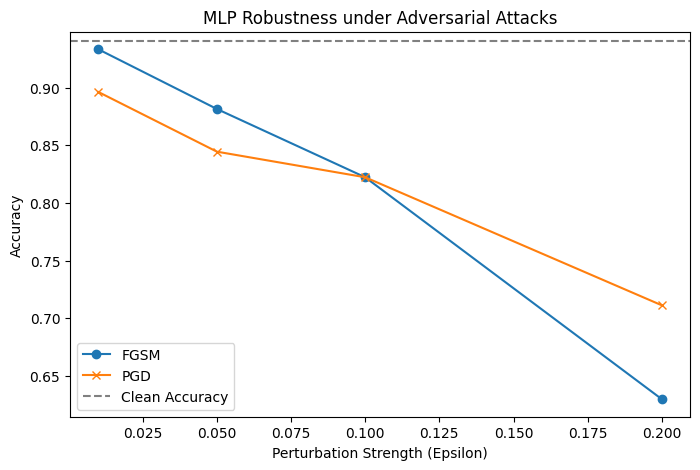

In [28]:
plt.figure(figsize=(8,5))
plt.plot(results["epsilon"], results["fgsm_acc"], marker="o", label="FGSM")
plt.plot(results["epsilon"], results["pgd_acc"], marker="x", label="PGD")
plt.axhline(clean_acc, color="gray", linestyle="--", label="Clean Accuracy")
plt.xlabel("Perturbation Strength (Epsilon)")
plt.ylabel("Accuracy")
plt.title("MLP Robustness under Adversarial Attacks")
plt.legend()
plt.show()
